In [0]:
import pandas as pd
import numpy as np

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram, scale_x_log10
from plotnine import geom_boxplot, scale_y_log10, geom_bar
from scipy.stats import pearsonr
import itertools
import scipy.stats as scs
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBClassifier



In [0]:
filepath = 'dataset/OUTPUT_WBI_exposer_cyclones_v6.csv'
df = pd.read_csv(filepath)

In [0]:
df.head(1)

,Unnamed: 0,SID,NAME,ISO,YEAR,BASIN,SUB BASIN,NATURE,ISO_TIME,COORDS,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CAL_MIN,WIND_CAL_MAX,WIND_CALC_MEAN,PRES_CAL_MIN,PRES_CAL_MAX,PRES_CALC_MEAN,STORM_SPD_MIN,STORM_SPD_MAX,STORM_SPD_MEAN,STORM_DR_MIN,STORM_DR_MAX,STORM_DR_MEAN,V_LAND_KN,34KN_ASSETS,64KN_ASSETS,96KN_ASSETS,CPI,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,"Air transport, freight (million ton-km)",Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP growth (annual %),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34,pop_max_50,pop_max_64,TOTAL_AFFECTED,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj
0,0,1949163N07145,DELLA,JPN,1949,WP,WP,TS,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",0,0,0,0,33.0,55.0,39.133333,982.0,1008.0,1000.333333,11,27,19.0,41,356,91.444444,99.82,NaN,NaN,NaN,9.327572,NaN,419.0,NaN,0.059615,4173.5,67.79,NaN,8607.657082,0.0,67.666098,NaN,258.911917,2.867878,36.728,Low,16278929.0,4378623.5,732154.8125,194046,0,0,0


In [0]:
df.shape

(1044, 53)

In [0]:
df.info()


'''
index
34KN_POP
64KN_POP
96KN_POP
Population, total             
Population_2000            
Population_2005            
Population_2010            
Population_2015            
Population_2020            
pop_max_34    
pop_max_50    
pop_max_64    
Numeric             
YEAR_tiff           
coef_year          
YEAR_tiff_c


############


-      USA_SSHS column with value -5 = Unknown [XX]:
df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)
-      As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate "Total Damage Adjusted" by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
-      Transform ‘Income_level_Final’ categories into ordinal: so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 44 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1005 non-null   int64  
 1   SID                                                  1005 non-null   object 
 2   NAME                                                 1005 non-null   object 
 3   ISO                                                  1005 non-null   object 
 4   YEAR                                                 1005 non-null   int64  
 5   BASIN                                                1005 non-null   object 
 6   SUB BASIN                                            1005 non-null   object 
 7   NATURE                                               1005 non-null   object 
 8   ISO_TIME                                             1005 non-null  

'\nindex\n34KN_POP\n64KN_POP\n96KN_POP\nPopulation, total             \nPopulation_2000            \nPopulation_2005            \nPopulation_2010            \nPopulation_2015            \nPopulation_2020            \npop_max_34    \npop_max_50    \npop_max_64    \nNumeric             \nYEAR_tiff           \ncoef_year          \nYEAR_tiff_c\n\n\n############\n\n\n-      USA_SSHS column with value -5 = Unknown [XX]:\ndf["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)\n-      As damage in \'000 USD is time-money sensitive, we can use the CPI for that data point to calculate "Total Damage Adjusted" by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.\ndf["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]\ndf["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)\ndf = df.drop(["TOTAL_DAMAGE_(000$)",\'CPI\'], axis=1)\n-      Transform ‘Income_level_Final’ categories into ordinal: so we assign[\'Low\' =1, \'Low_Midd

In [0]:
df = df.drop(columns=['pop_max_34', 'pop_max_50', 'pop_max_64', 'Unnamed: 0', "SID"])

In [0]:
## Xavier preprocessing

df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan)

df['SUB BASIN']= np.where(df['SUB BASIN'].isnull(), df['BASIN'], df['SUB BASIN'])

df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)


In [0]:
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)

In [0]:
df['SSHSS'] = np.where(df['USA_SSHS'] > 0, 1, 0)

df["SSHSS"] = df["SSHSS"].astype('object')

In [0]:
columns = ['BASIN', 'SUB BASIN', 'NATURE', 'Income_level_Final', 'USA_SSHS', 'SSHSS']

In [0]:
df.shape

(1044, 48)

In [0]:
df['USA_SSHS'].value_counts()

 0.0    352
-1.0    243
 1.0    153
 2.0     72
 4.0     65
 3.0     58
-3.0     21
-4.0     16
 5.0     13
-2.0      5
Name: USA_SSHS, dtype: int64

In [0]:
def checkNull(col, df):
  return(df[col].isna().sum() / len(df[col]) * 100.0)
  
for each in df.columns.values:
  print('{} ---- {}'.format(each, checkNull(each, df)))

NAME ---- 0.0
ISO ---- 0.0
YEAR ---- 0.0
BASIN ---- 0.0
SUB BASIN ---- 0.0
NATURE ---- 0.0
ISO_TIME ---- 0.0
COORDS ---- 0.0
TOTAL_HRS ---- 0.0
DAY_HRS ---- 0.0
NIGHT_HRS ---- 0.0
USA_SSHS ---- 0.6704980842911877
WIND_CAL_MIN ---- 0.0
WIND_CAL_MAX ---- 0.0
WIND_CALC_MEAN ---- 0.38314176245210724
PRES_CAL_MIN ---- 0.0
PRES_CAL_MAX ---- 0.0
PRES_CALC_MEAN ---- 0.0
STORM_SPD_MIN ---- 0.0
STORM_SPD_MAX ---- 0.0
STORM_SPD_MEAN ---- 0.0
STORM_DR_MIN ---- 0.0
STORM_DR_MAX ---- 0.0
STORM_DR_MEAN ---- 0.0
V_LAND_KN ---- 0.0
34KN_ASSETS ---- 23.371647509578544
64KN_ASSETS ---- 23.371647509578544
96KN_ASSETS ---- 23.371647509578544
TOTAL_DEATHS ---- 13.505747126436782
Air transport, freight (million ton-km) ---- 15.996168582375478
Arable land (hectares per person) ---- 0.09578544061302681
Cereal yield (kg per hectare) ---- 0.9578544061302682
Food production index (2004-2006 = 100) ---- 0.38314176245210724
GDP growth (annual %) ---- 3.8314176245210727
GDP per capita (constant 2010 US$) ---- 0.8620

In [0]:
df['SSHSS'].value_counts()

0    669
1    375
Name: SSHSS, dtype: int64

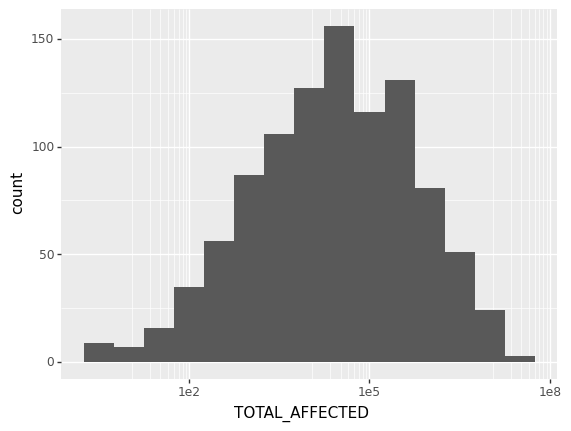

<ggplot: (8769328317020)>

In [0]:
(ggplot(df, aes(x='TOTAL_AFFECTED'))
 + geom_histogram(binwidth=0.5)
 + scale_x_log10())

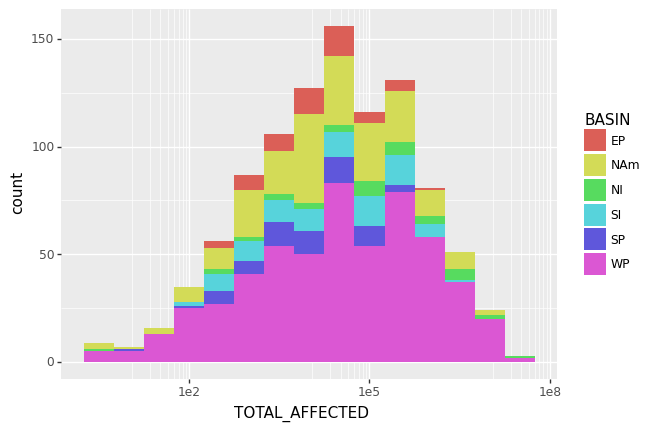

<ggplot: (8769325568527)>


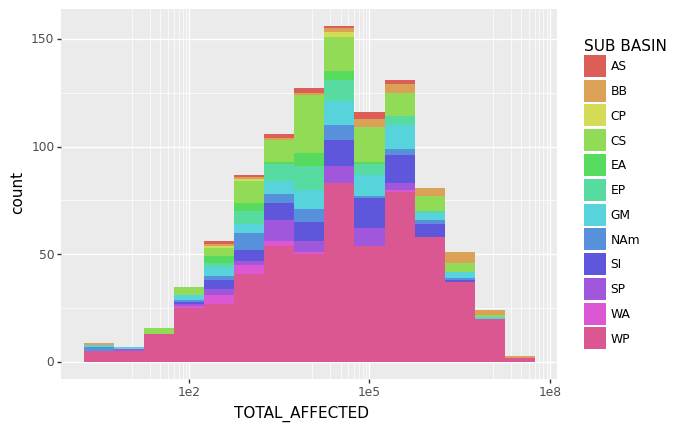

<ggplot: (-9223363267529203410)>


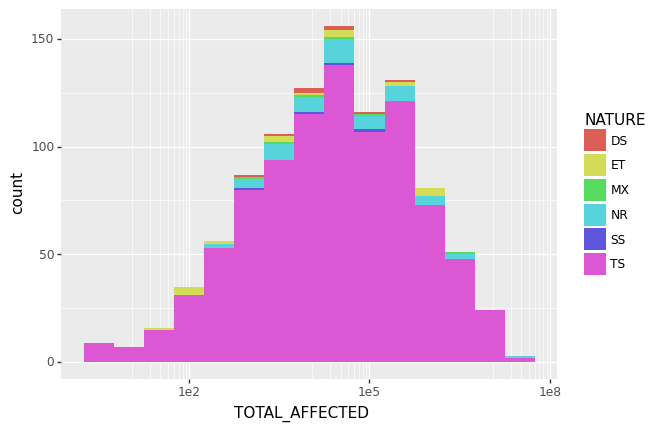

<ggplot: (8769325214640)>


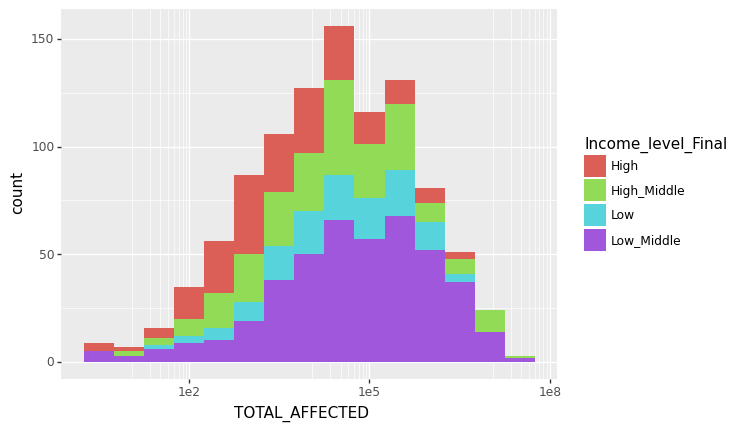

<ggplot: (-9223363267529664147)>


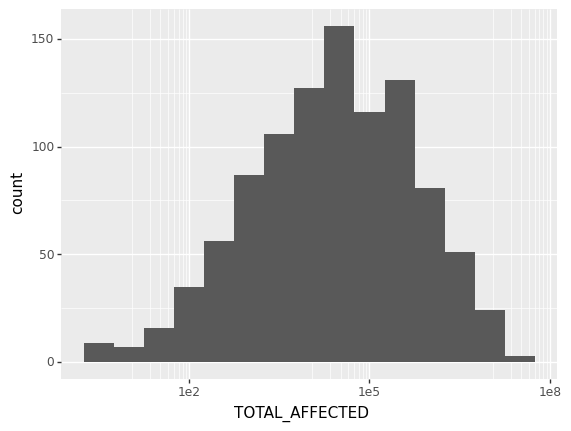

<ggplot: (8769325116115)>


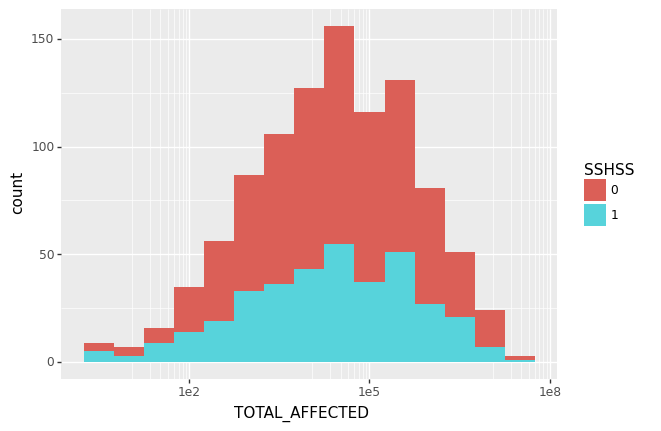

<ggplot: (8769325051389)>


In [0]:
for each in columns:
  plot = (ggplot(df, aes(x='TOTAL_AFFECTED', fill=each))
 + geom_histogram(binwidth=0.5)
 + scale_x_log10())
  
  print(plot)

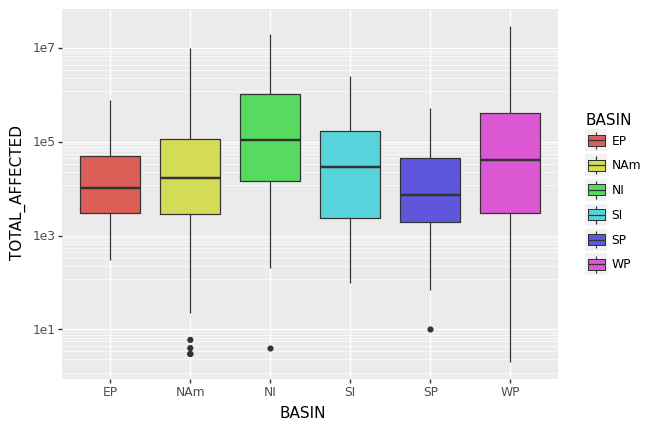

<ggplot: (-9223363267529553881)>


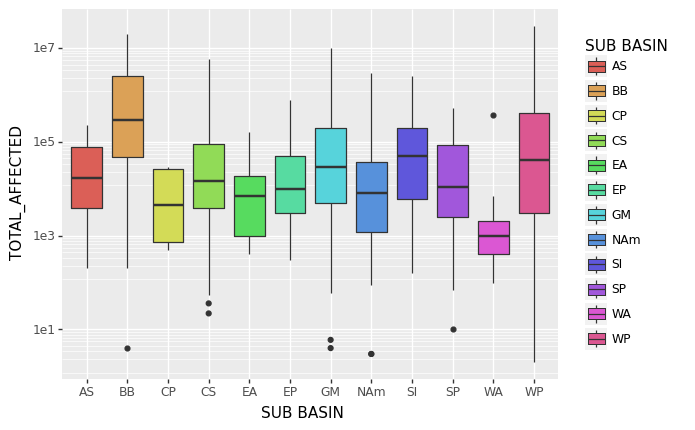

<ggplot: (8769324954737)>


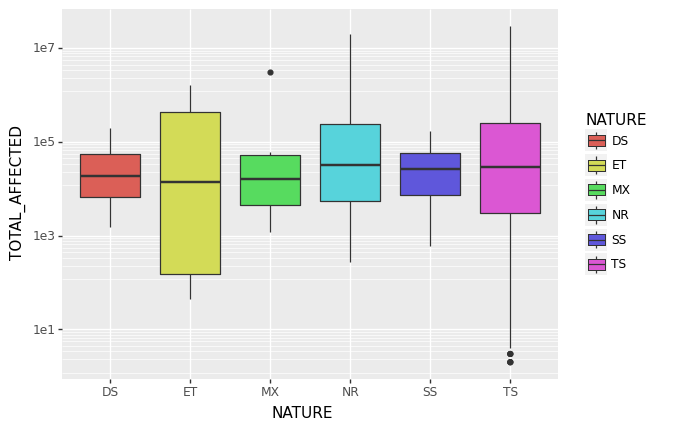

<ggplot: (-9223363267529717423)>


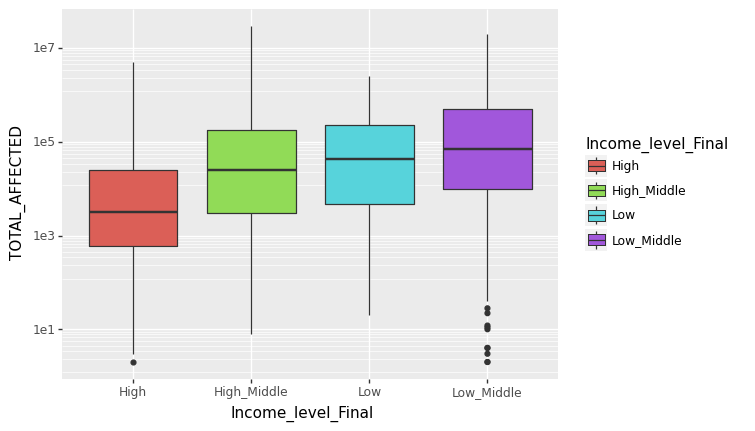

<ggplot: (-9223363267529213780)>


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 7 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


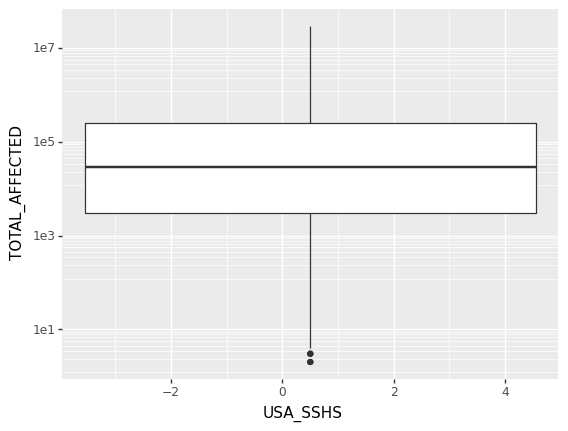

<ggplot: (8769325565248)>


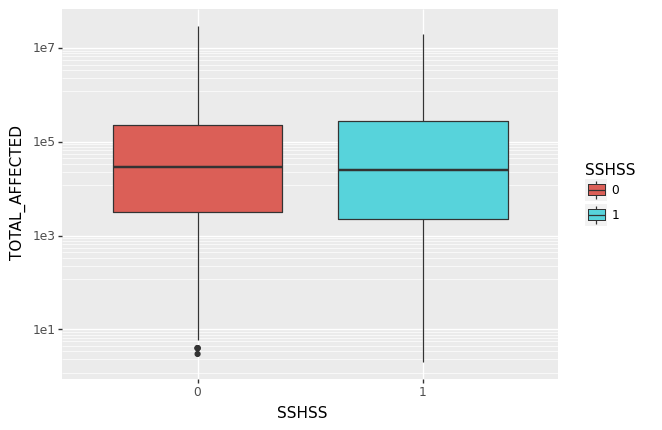

<ggplot: (-9223363267529786757)>


In [0]:

for each in columns:
  plot = (ggplot(df, aes(x=each, y='TOTAL_AFFECTED', fill=each))
          + geom_boxplot()
          + scale_y_log10())
  print(plot)

In [0]:
chi_sq_results = []
for i, j in itertools.combinations(object_columns, 2):
  cross_tab = pd.crosstab(df[i], df[j])
  chi_sq, p_val, _, _ = scs.chi2_contingency(cross_tab)
  chi_sq_results.append([i, j, chi_sq, p_val])

In [0]:
chi_sq_results

[['BASIN', 'SUB BASIN', 5088.250472760114, 0.0],
 ['BASIN', 'NATURE', 115.90682038950995, 1.159324989033322e-13],
 ['BASIN', 'Income_level_Final', 524.1088658194591, 4.461522088894435e-102],
 ['BASIN', 'SSHSS', 19.803912386256464, 0.001360151279022503]]

In [0]:
chi_sq_results = [x for x in chi_sq_results if x[3] > 0.05]

In [0]:
chi_sq_results

[]

In [0]:
## Point Biserial Correlation

scs.pointbiserialr(df['SSHSS'], np.log(df['TOTAL_AFFECTED']) + 1)

PointbiserialrResult(correlation=-0.03433806515396919, pvalue=0.2676482773038754)

In [0]:
all_columns = df.columns.values

to_remove = ['ID', 'NAME', 'ISO', 'Year', 'COORDS', 'ISO_TIME', '34kn_pop', 
             '34kn_assets', '64kn_pop', '64kn_assets', '96kn_pop', '96kn_assets',
             "Total damage ('000$)", 'Air transport, freight (million ton-km)']

to_remove.extend(['TOTAL_DAMAGE_(000$)_Adjusted', 'TOTAL_DEATHS', 
                  'Air transport, freight (million ton-km)', 'YEAR',
                  '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS'])


regression_columns = [x for x in all_columns if x not in to_remove]

no_na_df = df[regression_columns].dropna()





In [0]:
object_columns = [col for col in regression_columns if df[col].dtype == 'object']
dummies = pd.get_dummies(no_na_df[object_columns])



no_na_df = pd.concat([no_na_df, dummies], axis=1)

object_columns.append('SSHSS_1')
no_na_df = no_na_df.drop(columns=object_columns)

In [0]:
def checkNull(col, df):
  return(df[col].isna().sum() / len(df[col]) * 100.0)
  
for each in features:
  print('{} ---- {}'.format(each, checkNull(each, no_na_df)))

TOTAL_HRS ---- 0.0
DAY_HRS ---- 0.0
NIGHT_HRS ---- 0.0
USA_SSHS ---- 0.0
WIND_CAL_MIN ---- 0.0
WIND_CAL_MAX ---- 0.0
WIND_CALC_MEAN ---- 0.0
PRES_CAL_MIN ---- 0.0
PRES_CAL_MAX ---- 0.0
PRES_CALC_MEAN ---- 0.0
STORM_SPD_MIN ---- 0.0
STORM_SPD_MAX ---- 0.0
STORM_SPD_MEAN ---- 0.0
STORM_DR_MIN ---- 0.0
STORM_DR_MAX ---- 0.0
STORM_DR_MEAN ---- 0.0
V_LAND_KN ---- 0.0
Arable land (hectares per person) ---- 0.0
Cereal yield (kg per hectare) ---- 0.0
Food production index (2004-2006 = 100) ---- 0.0
GDP growth (annual %) ---- 0.0
GDP per capita (constant 2010 US$) ---- 0.0
Net flows from UN agencies US$ ---- 0.0
Life expectancy at birth, total (years) ---- 0.0
Mobile cellular subscriptions (per 100 people) ---- 0.0
Population density (people per sq. km of land area) ---- 0.0
Adjusted savings: education expenditure (% of GNI) ---- 0.0
Rural population (% of total population) ---- 0.0
pop_max_34_adj ---- 0.0
pop_max_50_adj ---- 0.0
pop_max_64_adj ---- 0.0
BASIN_EP ---- 0.0
BASIN_NAm ---- 0.0
BASI

In [0]:
features = [x for x in no_na_df.columns.values if x != 'TOTAL_AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(
    no_na_df[features], no_na_df['TOTAL_AFFECTED'], test_size=0.2, random_state=42)

In [0]:
### Standard Scaling

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_train)

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [0]:
train = TensorDataset(torch.Tensor(scaled_X), torch.Tensor(y_train.values).view(-1, 1))
train_loader = DataLoader(train, shuffle = True, batch_size = 32)

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.h1 = torch.nn.Linear(n_feature, n_hidden)
        self.h2 = torch.nn.Linear(n_hidden, n_hidden*2) 
        self.h3 = torch.nn.Linear(n_hidden*2, n_hidden*4) 

        self.lRelu = torch.nn.LeakyReLU(0.2)

        self.dropout = torch.nn.Dropout(0.4)

        self.out = torch.nn.Linear(n_hidden*4, n_output)

    def forward(self, x):
        x = self.lRelu(self.h1(x))      
        x = self.dropout(x)

        x = self.lRelu(self.h2(x))   
        x = self.dropout(x)

        x = self.lRelu(self.h3(x))   
        x = self.dropout(x)

        x = self.out(x)             
        return(x)


def create_model(n_features, n_hidden, n_output):
  clf = nn.Sequential(
      nn.Linear(n_features, n_hidden), 
      nn.Linear(n_hidden, n_output), 
  )

  return(clf)

In [0]:
model = Net(X_train.shape[1], 16, 1)

optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
criterion = torch.nn.MSELoss()

epochs = 10

In [0]:
model

Sequential(
  (0): Linear(in_features=60, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=1, bias=True)
)

In [0]:
losses = []
for n in range(1, epochs):
  model.train()

  for X, Y in train_loader:

    optimizer.zero_grad()

    pred = model(X)

    loss = criterion(pred, Y)

    loss.backward()
    optimizer.step()

    losses.append(loss)

    print("Epoch - {}  Loss - {} ".format(n, loss))

Epoch - 1  Loss - 223465013248.0 
Epoch - 1  Loss - 1442663759872.0 
Epoch - 1  Loss - 2896705617920.0 
Epoch - 1  Loss - 1735577042944.0 
Epoch - 1  Loss - 1185390919680.0 
Epoch - 1  Loss - 13885014802432.0 
Epoch - 1  Loss - 215750918144.0 
Epoch - 1  Loss - 694562258944.0 
Epoch - 1  Loss - 1422808449024.0 
Epoch - 1  Loss - 1726775558144.0 
Epoch - 1  Loss - 175878995968.0 
Epoch - 1  Loss - 3464466530304.0 
Epoch - 1  Loss - 11246505033728.0 
Epoch - 1  Loss - 370211356672.0 
Epoch - 1  Loss - 1811404685312.0 
Epoch - 1  Loss - 12785747492864.0 
Epoch - 1  Loss - 4165356748800.0 
Epoch - 1  Loss - 245427109888.0 
Epoch - 1  Loss - 2451003932672.0 
Epoch - 1  Loss - 5835623759872.0 
Epoch - 1  Loss - 319142199296.0 
Epoch - 1  Loss - 14417592844288.0 
Epoch - 1  Loss - 198898089984.0 
Epoch - 1  Loss - 1233288036352.0 
Epoch - 1  Loss - 792533925888.0 
Epoch - 2  Loss - 2410749886464.0 
Epoch - 2  Loss - 8541775069184.0 
Epoch - 2  Loss - 7298070609920.0 
Epoch - 2  Loss - 8629402

In [0]:
losses

In [0]:
### Keras

In [0]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras import callbacks, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [0]:
def build_model():
  clf = Sequential()

  clf.add(Dense(32, input_shape=(X_train.shape[1], )))
  clf.add(LeakyReLU(0.2))
  clf.add(Dropout(0.5))

  clf.add(Dense(64))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.4))
  
  clf.add(Dense(128))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.4))

  clf.add(Dense(256))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.3))

  clf.add(Dense(1))

  return(clf)



In [0]:
keras_model = build_model()

optim = optimizers.RMSprop(learning_rate=0.001)

keras_model.compile(loss='mse', optimizer=optim, metrics=['mae'])

callback = [EarlyStopping(monitor='val_loss', patience=100, 
                                              verbose=1, mode='min'), 
            ModelCheckpoint('model.sve', monitor='val_loss', verbose=True, 
                            save_best_only=True, mode='min')]


In [0]:
history = keras_model.fit(np.array(X_train), np.array(y_train), epochs=1000, 
                          validation_split=0.1, batch_size=32, callbacks=callback)

Train on 709 samples, validate on 79 samples
Epoch 1/1000
709/709 [==============================] - 0s 193us/step - loss: 5268357422907.5771 - mae: 818169.9375 - val_loss: 1118250341648.2026 - val_mae: 589192.6875

Epoch 00001: val_loss improved from inf to 1118250341648.20264, saving model to model.sve
Epoch 2/1000
709/709 [==============================] - 0s 64us/step - loss: 3761533989932.7729 - mae: 745883.0625 - val_loss: 1950462948313.1140 - val_mae: 831716.9375

Epoch 00002: val_loss did not improve from 1118250341648.20264
Epoch 3/1000
709/709 [==============================] - 0s 69us/step - loss: 3581010004623.7065 - mae: 767169.8125 - val_loss: 1641199395127.0886 - val_mae: 754399.5000

Epoch 00003: val_loss did not improve from 1118250341648.20264
Epoch 4/1000
709/709 [==============================] - 0s 66us/step - loss: 3649847334926.4424 - mae: 762858.3125 - val_loss: 851685987911.2911 - val_mae: 412816.9375

Epoch 00004: val_loss improved from 1118250341648.20264 to 

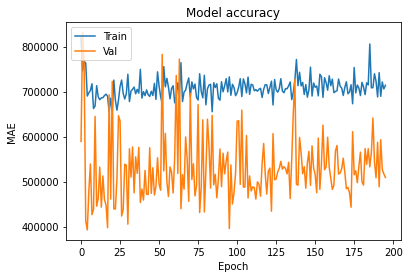

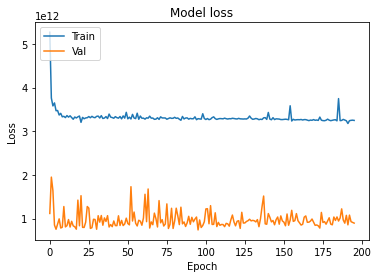

In [0]:
# Plot training & validation mae values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Performance')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation mse-loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

197/197 [==============================] - 0s 226us/step


[7499312190084.548, 776335.25]